#Bengali Digit Recognition using Hidden Markov Model
By Dibyendu Das \\
M.Sc in Big Data Analytics \\
Ramakrishna Mission Vivekananda Educational and Research Institute


---




# Import necessary libraries

In [ ]:
pip install hmmlearn

In [ ]:
pip install python_speech_features

In [ ]:

import itertools
import os
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from hmmlearn import hmm
from scipy.io import wavfile
from python_speech_features import mfcc, logfbank, delta
import matplotlib.pyplot as plt
import pickle   
import warnings
import librosa
warnings.filterwarnings("ignore")


#Visualization of our dataset

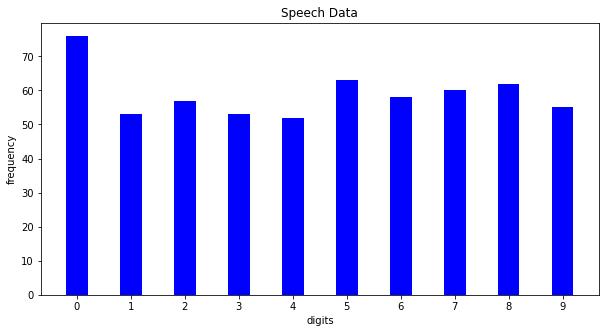

In [ ]:
files = sorted(os.listdir(directory))
n = len(files)
data = dict()
for i in  range(n):
  digit = files[i][0]
  if digit not in data.keys():
    data[digit] = []
  else :
    data[digit].append(1)

    
data1 = dict()
for key ,value in data.items():
  data1[key] = len(value)
data1 
  
# creating the dataset
data = data1
courses = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(courses, values, color ='blue',
        width = 0.4)
 
plt.xlabel("digits")
plt.ylabel("frequency")
plt.title("Speech Data")
plt.show()

  Digit  person 1  person 2  person 3  ...  person 5  person 6  person 7  person 8
0     0        10        10        10  ...        10        10         9         7
1     1        10        10         8  ...         5         5         5         5
2     2        10        10        10  ...         5         5         5         7
3     3        10        10         8  ...         5         5         5         5
4     4        10         9         8  ...         5         5         5         5
5     5        10        10        10  ...         5         5         9         9
6     6        10         7         8  ...         5         5         9         9
7     7        10         7         8  ...         5         5         6         9
8     8         8         9         8  ...         7         5         6         9
9     9        10         8        10  ...         5         5         5         7

[10 rows x 9 columns]


<Figure size 720x360 with 0 Axes>

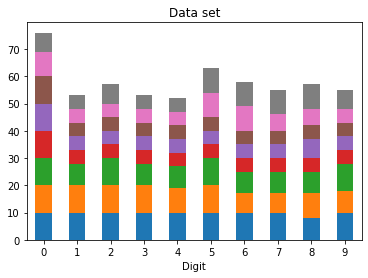

In [ ]:
# Here we plot the contribution of each person to our dataset
# create data
df = pd.DataFrame([['0', 10,10 , 10, 10,10,10,9,7],['1', 10,10 , 8, 5,5,5,5,5], ['2', 10,10 , 10, 5,5,5,5,7],
                   ['3', 10,10 , 8, 5,5,5,5,5],['4', 10,9 , 8, 5,5,5,5,5],['5', 10,10 , 10, 5,5,5,9,9],
                   ['6', 10,7 , 8, 5,5,5,9,9],['7', 10,7 , 8, 5,5,5,6,9],['8', 8,9 , 8, 5,7,5,6,9],
                   ['9', 10,8 , 10, 5,5,5,5,7]],
                  columns=['Digit', 'person 1', 'person 2', 'person 3', 'person 4','person 5','person 6','person 7','person 8'])
# view data
print(df)
  
# plot data in stack manner of bar type
plt.figure(figsize=(10,5))
df.plot(x='Digit', kind='bar', stacked=True,
        title='Data set',legend = False,rot=0)

#Data loader

In [ ]:
directory = "/content/drive/MyDrive/data/"

In [ ]:

def build_dataset(sound_path=directory):
    files = sorted(os.listdir(sound_path))
    x_train = []
    y_train = []
    x_test = []
    y_test = []
    data = dict()
    n = len(files)
    print(n)
    for i in range(n):
      feature = feature_extractor(sound_path=sound_path + files[i])
      digit = files[i][0]                           # as our file format is in the form "01.wav" ,"512.wav"
      if digit not in data.keys():                  # in this the first digit is our class i.e in "01.wav"--> 0is our clss
          data[digit] = []                          # "512.wav"-->5 is our class
          x_test.append(feature)
          y_test.append(digit)
      else:
          if np.random.rand() < 0.2:                #Split our train data and test data in 80%-20%  format
              x_test.append(feature)
              y_test.append(digit)
          else:
              x_train.append(feature)
              y_train.append(digit)
              data[digit].append(feature)
    return x_train, y_train, x_test, y_test, data


#Normalize  wave data and Extracting MFCC Features

In [ ]:
def audio_norm(data):
    max_data = np.max(data)
    min_data = np.min(data)
    data = (data-min_data)/(max_data-min_data+1e-6)
    return data-0.55

In [ ]:
def feature_extractor(sound_path):
    sampling_freq, audio = wavfile.read(sound_path)            #read audio file
    audio = audio_norm(audio)                                  #normalize audio file
    # print(audio)
    mfcc_features = mfcc(audio, sampling_freq,nfft = 2048,numcep=13,nfilt=13) # Extracting mfcc feature for each audio file
    return mfcc_features                                        # here we only take 13 cepstrum value


#In this section we define our Train Model and Prediction Method

In [ ]:
def train_model(data):
  learned_hmm = dict()                                                #as we are going to create TEN(10) models for 10 digits
  for label in data.keys():                                           #for that reason we are creating a dictionary
    model = hmm.GMMHMM(verbose=False,n_components=10,n_mix=8, n_iter=200)    
                                                                     #here number of components are 10 and number of gaussian mixture
    feature = np.ndarray(shape=(1, 13))                              #is 8
    for list_feature in data[label]:
      # print(np.array(list_feature).shape)

      feature = np.vstack((feature, list_feature))                    #we stack all features corresponding to one digit
      # print(np.array(feature).shape)
    print(feature,np.array(feature).shape) 
    obj = model.fit(feature)                                         #for each digit we fit a model
    learned_hmm[label] = obj
  return learned_hmm


In [ ]:

def prediction(test_data, trained):
  # predict list of test
  predict_label = []
  names = []
  if type(test_data) == type([]):                               # if test data is ia list then drive into this loop
      for test in test_data:
          scores = []
          for node in trained.keys():                           #for each digit in test set we predict scores from
              scores.append(trained[node].score(test))          #10 different models ,i.e we get a list [a,b,c,d,e,f,g,h,i,j]
              print(scores)                                     # and after getting the scores we take the maximum one
              names.append(node)                              
          predict_label.append(scores.index(max(scores)))
  else:
      scores = []
      for node in trained.keys():
          scores.append(trained[node].score(test_data))
          names.append(node)
      predict_label.append(scores.index(max(scores)))
  return names[predict_label[0]]

In [ ]:
def score(test_data, trained):                           #I define this score function for getting score from different
  if type(test_data) == type([]):                        # trained models for a single wave file
    scores = []
    names = []
    for node in trained.keys():
      scores.append(trained[node].score(test_data))      #trained[node] is associated with a perticular hmm for a digit
      names.append(node)                                 #trained[node].score(test_data) gives a score corresponding to 
                                                         #that specific hmm
  else :
    scores = []
    names = []
    for node in trained.keys():
      names.append(node)
      scores.append(trained[node].score(test_data))
  return scores - min(scores)                            #scores are generally in negative sign ,
                                                         #for positive score we do scores - min(scores)   

In [ ]:

def plot_confusion_matrix(cm, classes,                   # I define this function for ploting Confusuion Matrix
                          normalize=False,
                          title='Confusion matrix',                    
                          cmap=plt.cm.Blues)
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()


In [ ]:

def report(y_test, y_pred, show_cm=True):
  print("confusion_matrix:\n\n", confusion_matrix(y_test, y_pred))
  print("----------------------------------------------------------")
  print("----------------------------------------------------------\n")
  print("classification_report:\n\n", classification_report(y_test, y_pred))
  print("----------------------------------------------------------")
  print("----------------------------------------------------------\n")
  print("Accuracy:", accuracy_score(y_test, y_pred))
  print("----------------------------------------------------------")
  print("----------------------------------------------------------\n")
  if show_cm:
      plot_confusion_matrix(confusion_matrix(y_test, y_pred), [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


In [ ]:
'''
so basically have the data folder in same directory change name of folder in code accordingly
block 1 down in the code for training and dumping in pickle file
block 2 for opening trained weights from pickle file
block 3 for testing on whatever accordingly see
'''

In [ ]:
x_train, y_train, x_test, y_test, data = build_dataset()

In [ ]:
'''Block 1 start'''

learned_hmm = train_model(data)                  #train our model and save as .pkl file
with open("learned.pkl", "wb") as file:
    pickle.dump(learned_hmm, file)
print("training done")
'''Block 1 end'''

[[ 1.          2.56546322  4.09905813 ... 11.88803586 12.
  11.88803586]
 [-4.30945655 -7.99407128 -1.01982264 ...  2.67198482  2.3350247
  -0.72284642]
 [-4.40428222 -8.7230757  -8.03497637 ...  6.74597209  2.889353
   0.99956068]
 ...
 [-6.01129132  8.13481919  8.94002474 ... -2.99591235  0.29859697
   5.32863318]
 [-6.01106987  8.4351306   8.39145119 ... -3.86634403  0.6907249
   5.2467493 ]
 [-6.30750228  8.76036876  8.7562141  ... -4.38374722  2.08896043
   4.71936014]] (12049, 13)
[[-3.67141089 -4.19094936  5.48189656 ...  2.21364083  0.59080236
  -0.45791666]
 [-3.41712879 -7.68073928  3.22999316 ...  1.21772903  3.94286642
  -1.10519024]
 [-3.85471192 -6.83904584  8.73762876 ...  4.19035227  3.54062551
  -0.28103168]
 ...
 [-4.02978754 13.28089907  9.49679016 ...  2.89074743  1.62171293
   1.3868739 ]
 [-4.02990301 13.30865344  9.77563051 ...  3.05123124  0.70024891
   1.93562987]
 [-4.32562024 13.49532997  9.53445316 ...  2.94480814  0.87165438
   1.70441468]] (7570, 13)
[[ -3

'Block 1 end'

In [ ]:
'''Block 2 start'''
with open("learned.pkl", "rb") as file:
    learned_hmm = pickle.load(file)         #open the pkl file
'''Block 2 start'''

'Block 2 start'

confusion_matrix:

 [[16  0  0  0  0  0  1  0  0  1]
 [ 0  7  0  0  0  1  0  1  0  0]
 [ 0  0 16  1  0  0  0  0  0  0]
 [ 0  0  0 12  1  0  0  0  0  0]
 [ 0  0  0  0  4  2  0  1  3  0]
 [ 0  0  0  0  1  8  0  0  1  0]
 [ 0  0  0  0  2  0  6  2  0  1]
 [ 0  0  0  0  1  2  0  7  0  0]
 [ 1  0  0  0  0  2  0  4 11  0]
 [ 0  0  0  0  0  0  1  0  0  5]]
----------------------------------------------------------
----------------------------------------------------------

classification_report:

               precision    recall  f1-score   support

           0       0.94      0.89      0.91        18
           1       1.00      0.78      0.88         9
           2       1.00      0.94      0.97        17
           3       0.92      0.92      0.92        13
           4       0.44      0.40      0.42        10
           5       0.53      0.80      0.64        10
           6       0.75      0.55      0.63        11
           7       0.47      0.70      0.56        10
           8      

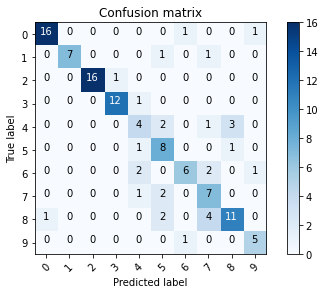

confusion_matrix:

 [[55  0  1  0  0  2  0  0  1  0]
 [ 0 41  0  0  0  1  0  1  2  0]
 [ 0  0 41  0  0  0  0  0  0  0]
 [ 0  0  1 36  0  1  0  0  2  1]
 [ 0  0  0  0 40  0  0  2  1  0]
 [ 0  0  0  0  0 54  0  0  0  0]
 [ 0  0  0  0  0  2 44  0  2  0]
 [ 0  0  0  0  0  0  0 51  0  0]
 [ 0  0  0  0  0  0  0  0 45  0]
 [ 0  0  0  0  0  0  0  0  0 50]]
----------------------------------------------------------
----------------------------------------------------------

classification_report:

               precision    recall  f1-score   support

           0       1.00      0.93      0.96        59
           1       1.00      0.91      0.95        45
           2       0.95      1.00      0.98        41
           3       1.00      0.88      0.94        41
           4       1.00      0.93      0.96        43
           5       0.90      1.00      0.95        54
           6       1.00      0.92      0.96        48
           7       0.94      1.00      0.97        51
           8      

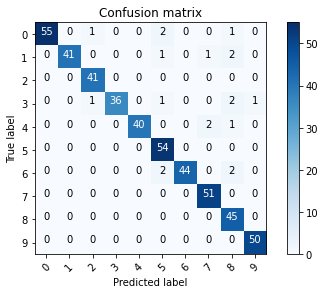

########################## TRAINING ACCURACY ######################################
0.9580712788259959
########################## TESTING ACCURACY #######################################
0.7540983606557377


'Block 3 end'

In [ ]:
'''Block 3 start'''
files = sorted(os.listdir(directory))
tot_test = 0
tot_train = 0
n = len(x_test)
m = len(x_train)
pred_test = []
pred_train = []
for i in range(n):
    y_pred = prediction(x_test[i], learned_hmm)     # here we call our predefine prediction function 
    if y_pred == y_test[i]:                         # if our prediction matches with our correct label then we increase
        tot_test += 1                               # our right prediction by 1
    pred_test.append(y_pred)                         # we do this both for our train and test set
for i in range(m):
    y_pred = prediction(x_train[i], learned_hmm)
    if y_pred == y_train[i]:
        tot_train += 1
    pred_train.append(y_pred)

report(y_test,pred_test)
report(y_train,pred_train)
print('########################## TRAINING ACCURACY ######################################')
print(tot_train/m)
print('########################## TESTING ACCURACY #######################################')
print(tot_test/n)

'''Block 3 end'''

# Plot  Digit wise accuracy

In [ ]:
matrix = confusion_matrix((y_test, pred_test), [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])    # Digit wise accuracy for test set
test = matrix[0].diagonal()/matrix[0].sum(axis=1)                                        


In [ ]:
matrix1 = confusion_matrix(y_train, pred_train), [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]   # Digit wise accuracy for train set
train = matrix1[0].diagonal()/matrix1[0].sum(axis=1)

#Digit wise accuracy for test set

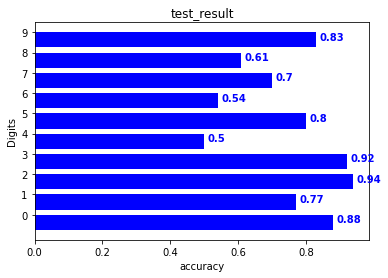

In [ ]:
fig, ax = plt.subplots() 
x = ['0','1','2','3','4','5','6','7','8','9']
y = [0.88 ,0.77 ,0.94,0.92,0.5,0.8,0.54,0.7,0.61,0.83]
width = 0.75 # the width of the bars 
ind = np.arange(len(y))  # the x locations for the groups
ax.barh(ind, y, width, color="b")
ax.set_yticks(ind+width/2)
ax.set_yticklabels(x, minor=False)
plt.title('test_result')
plt.xlabel('accuracy')
plt.ylabel('Digits')  
for i, v in enumerate(y):
    ax.text(v+0.01, i, str(v), color='blue', fontweight='bold')


#Digit wise accuracy for train set

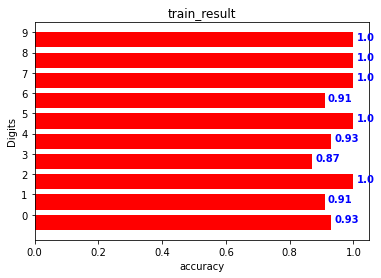

In [ ]:
fig, ax = plt.subplots() 
x = ['0','1','2','3','4','5','6','7','8','9']
y = [0.93 ,0.91 ,1.0,0.87,0.93,1.0,0.91,1.0,1.0,1.0]
width = 0.75 # the width of the bars 
ind = np.arange(len(y))  # the x locations for the groups
ax.barh(ind, y, width, color="r")
ax.set_yticks(ind+width/2)
ax.set_yticklabels(x, minor=False)
plt.title('train_result')
plt.xlabel('accuracy')
plt.ylabel('Digits')  
for i, v in enumerate(y):
    ax.text(v+0.01, i, str(v), color='blue', fontweight='bold')

#Here we plot the scores given by Ten different Models and Highlight The maximum one by RED colour 

In [ ]:

single_test = feature_extractor('/content/drive/MyDrive/data/5-12.wav')   # given wave file corresponds to digit 5
value = score(single_test, learned_hmm)                                   # maximum score given by hmm model which corresponds to digit 5

Text(0, 0.5, 'Scores')

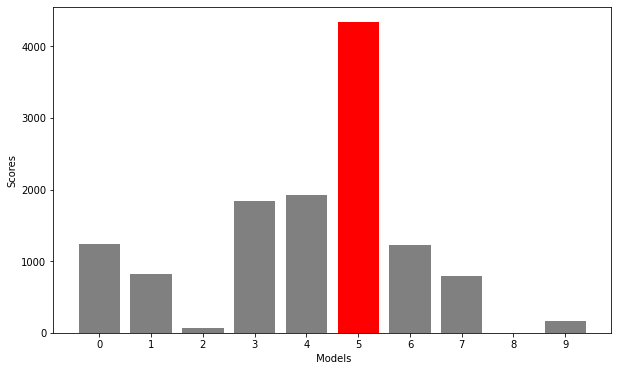

In [ ]:
plt.figure(figsize=(10,6))
clrs = ['grey' if (x < max(value)) else 'red' for x in value ]
idx =np.array(['0','1','2','3','4','5','6','7','8','9'])
plt.bar(idx, value, color=clrs)

plt.xlabel(" Models")
plt.ylabel("Scores")

# In this section i play with parameters and write down the training and testing accuracy

1.   Number of states = 3 ||
Number of Mixture = 2 ||
Number of Iteration = 100 ||
training Accuracy = 0.64344 ||
testing Accuracy = 0.4324
2. Number of states = 5 ||
Number of Mixture = 2 ||
Number of Iteration = 100 ||
training Accuracy = 0.77 ||
testing Accuracy = 0.55  


3.   Number of states = 7 ||
Number of Mixture = 2 ||
Number of Iteration = 100 ||
training Accuracy = 0.8278 ||
testing Accuracy = 0.612 
4.  Number of states = 10 ||
Number of Mixture = 2 ||
Number of Iteration = 100 ||
training Accuracy = 0.91 ||
testing Accuracy = 0.67 


5.   Number of states = 10 ||
Number of Mixture = 3 ||
Number of Iteration = 100 ||
training Accuracy = 0.9672 ||
testing Accuracy = 0.6846
6.   Number of states = 10 ||
Number of Mixture = 4 ||
Number of Iteration = 100 || 
training Accuracy = 0.901 || 
testing Accuracy = 0.7117 


7.   Number of states = 10 ||
Number of Mixture = 5 ||
Number of Iteration = 100 || 
training Accuracy = 0.92 ||
testing Accuracy = 0.7217
8.   Number of states = 10 ||
Number of Mixture = 7 ||
Number of Iteration = 150 ||
training Accuracy = 0.93 ||
testing Accuracy = 0.70


9.   Number of states = 12 ||
Number of Mixture = 8 || 
Number of Iteration = 300 ||
training Accuracy = 0.96 ||
testing Accuracy = 0.742
10. Number of states = 20 ||
Number of Mixture = 9 ||
Number of Iteration = 300 ||
training Accuracy = 0.99 || 
testing Accuracy = 0.78 




#Training and testing accuracy when number of states are fixed

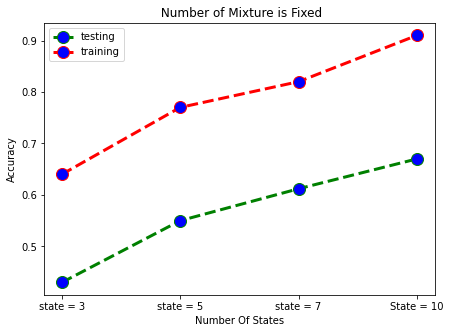

In [ ]:
l = [0.43 ,0.55 ,0.612 ,0.67]
t = [0.64 ,0.77, 0.82 ,0.91]
x = ['state = 3','state = 5','state = 7','State = 10']
plt.figure(figsize=(7,5))
plt.plot(x, l, color='green', linestyle='dashed', linewidth = 3,
         marker='o', markerfacecolor='blue', markersize=12)
plt.plot(x, t, color='red', linestyle='dashed', linewidth = 3,
         marker='o', markerfacecolor='blue', markersize=12)
plt.xlabel("Number Of States")
plt.ylabel("Accuracy")
plt.title(" Number of Mixture is Fixed")
plt.legend(['testing','training'])

##Training and testing accuracy when number of gaussian mixtures are fixed

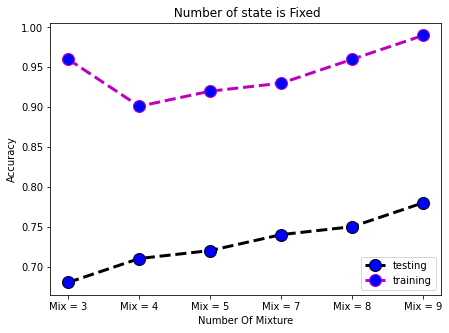

In [ ]:
t1 = [0.96,0.901,0.92,0.93,0.96,0.99]
l1 = [0.68 ,0.71 ,0.72,0.74,0.75,0.78]
plt.figure(figsize=(7,5))
x = ['Mix = 3','Mix = 4','Mix = 5','Mix = 7','Mix = 8','Mix = 9']
plt.plot(x, l1, color='black', linestyle='dashed', linewidth = 3,
         marker='o', markerfacecolor='blue', markersize=12)
plt.plot(x, t1, color='m', linestyle='dashed', linewidth = 3,
         marker='o', markerfacecolor='blue', markersize=12)
plt.xlabel("Number Of Mixture")
plt.ylabel("Accuracy")
plt.title(" Number of state is Fixed")
plt.legend(['testing','training'])